# Introduction to image processing

> **Skills to take away**
>
> - *Basic*: Load/plot an image (data type), color/grayscale, add/subtract two images
> - *Medium*: Zone modification, filters (kernels/blocks/windows), apply them (given functions)
> - *Expert*: Filter application function (notion/use of NumPy strides, 2D convolutions)

## Motivations

Image processing plays an important role in data science and science in general. The typical digit recognition problem is one (classic) example of image processing. The notion of *convolutional neural networks* (CNN) is also a key point in image processing based on machine learning algorithms. Another more recent example is the *generative adversarial neural networks* (GAN), which are able to generate images of a given nature, after being properly trained. You can check out [https://thispersondoesnotexist.com](https://thispersondoesnotexist.com), which shows generated images of people who don't actually exist.

The very first step is to understand how an image is encoded in NumPy and how to manipulate it, even without talking about sophisticated algorithms. This is the goal of this notebook, which is split into three different sections:

1. **Basic Investigations**: Load/plot/write an image, get image histogram, grayscale, cropping, ...
2. **Numerical Operations**: Addition, subtraction, masking some pixels based on a given condition, ...
3. **Applying Basic Filters**: Image split into blocks versus windows, blurring, sharpening, edge detection, ...

Note that there are a few Python packages dedicated to image processing, such as [Pillow](https://pillow.readthedocs.io/en/stable/) or [scikit-image](https://scikit-image.org/). The `scipy` package also has a module called `ndimage` dedicated to image processing (see this [online lecture](http://scipy-lectures.org/advanced/image_processing/)). I chose not to use these tools here in order to not increase the number of libraries (which is very easy to do in Python), so *only NumPy and matplotlib will be used in this chapter*. However, if you are interested in doing intensive image processing, I would recommend looking at Pillow. Another tool, more oriented toward machine learning and computer vision, is [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/index.html) - good to keep in mind depending on your applications.

## Basic investigations

An image is a NumPy array of 8-bit integers with a shape `(Nx, Ny, 3)`, where `Nx` and `Ny` represent the number of pixels in the x and y directions, respectively. The array contains three color channels (red, green, and blue), with each channel represented by an integer in the range [0, 255]. In this range, lower pixel values correspond to darker areas, while values closer to 255 represent brighter pixels. To load an image in a common format (such as png or jpg) as a NumPy array, you can use the `plt.imread()` function:

In [1]:
# Usual import
import numpy as np
import matplotlib.pyplot as plt

# Load a test image
im = plt.imread('../data/image_test.jpg')

Indeed, we can investigate the NumPy array we loaded:

In [2]:
# Print caracteristics
print('Object    : {}'.format(type(im)))
print('Shape     : {}'.format(im.shape))
print('Data type : {}'.format(im.dtype))

# Print the values of four first pixels along x (for y=0):
print('pixels(x<5, y=0): \n{}'.format(im[0:4, 0, :]))

Object    : <class 'numpy.ndarray'>
Shape     : (3008, 4008, 3)
Data type : uint8
pixels(x<5, y=0): 
[[18 18  8]
 [21 21  9]
 [31 31 19]
 [29 29 17]]


### Plotting

The obvious first thing we want to do with an image is to see it! This can be achieved using the `plt.imshow()` function. Below, we write a function that uses `plt.imshow()`, with an arbitrary figure size while keeping the figure ratio:

In [3]:
def plot_image(im, h=5, **kwargs):
    lx, ly = im.shape[:2]
    w = (ly/lx)*h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation=None, **kwargs)
    return

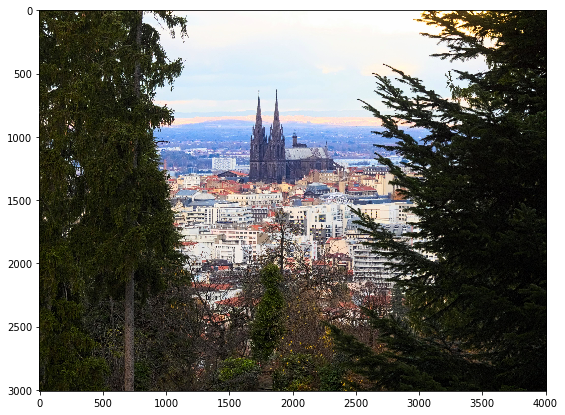

In [4]:
plot_image(im, h=7)

### Histograms

The histogram of an image is often shown on a camera or in post-processing picture software. This allows us to appreciate how all pixels are distributed in terms of intensity. This can be obtained with a rather straightforward function:

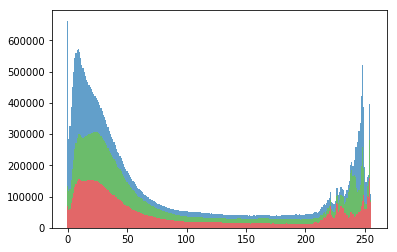

In [5]:
def plot_histogram(image):
    
    # Get the 2D array for each of the three colors, and flat it.
    pixels = [p.ravel() for p in np.array_split(image, 3, axis=2)]
    
    # Produce the histogram for each color and stack them
    style_hist = {'bins': np.arange(-0.5, 256.5, 1.0), 'alpha': 0.7, 'stacked':True}
    plt.hist(pixels, color=['tab:red', 'tab:green', 'tab:blue'], **style_hist)
    return
    
plot_histogram(im)

### Color and grayscale

It is also possible to plot each channel (color) separately. First, we can crop the picture to focus on the interesting part of it: the Clermont-Ferrand cathedral. Since the image is a NumPy array, cropping is just taking a sub-array using NumPy indexing:

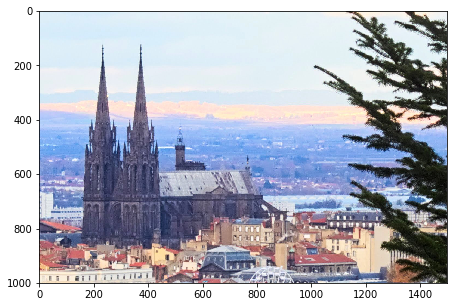

In [6]:
image = im[500:1500, 1500:3000]
plot_image(image)

For instance, we can plot the histogram of this new image and check that the dark parts corresponding to surrounding trees (low values) are significantly decreased.

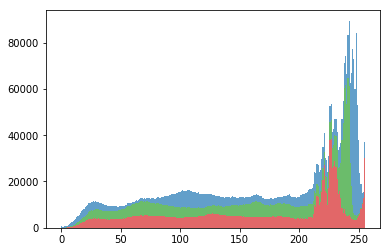

In [7]:
plot_histogram(image)

In order to investigate how the colors are spatially distributed, one can plot each channel separately using the appropriate color map. This is what the next function does:

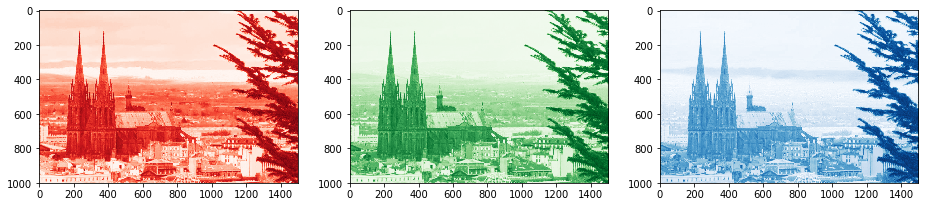

In [8]:
def plot_RGB(image):
    '''Plot each color channel'''
    
    # Get each color channel
    R, G, B = image[...,0], image[...,1], image[...,2]
    
    # Figure shape preserving the image ratio
    lx, ly = image.shape[:2]
    w = (ly/lx)*3
    fig = plt.figure(figsize=(w*3.5,5))
    
    # One subplot per channel (Nrow, Ncol, Nplot)
    for i, (pixel, color) in enumerate(zip([R, G, B], ['Reds_r', 'Greens_r', 'Blues_r'])):
        plt.subplot(1, 3, i+1)
        plt.imshow(pixel, interpolation=None, cmap=color)
    return
    
plot_RGB(image)

Another usual operation is to switch from colored to grayscale picture. This can be done in several ways (check for *e.g.* the corresponding [Wikipedia article](https://en.wikipedia.org/wiki/Grayscale)), but one which is relatively simple to implement is based on luminance preservation:

In [9]:
def get_gray_scale(image):
    
    # Get RGB individual values
    R, G, B = image[...,0], image[...,1], image[...,2]

    # Get gray scale from RGB colors: PIX = 0.299 R + 0.587 G + 0.114 B
    pixels = np.array(0.299*R + 0.587*G + 0.114*B, dtype=np.uint8)

    # Replace each channel by this gray scale
    im_gs = np.stack([pixels, pixels, pixels], axis=2)
    
    # Retrun the gray image
    return im_gs

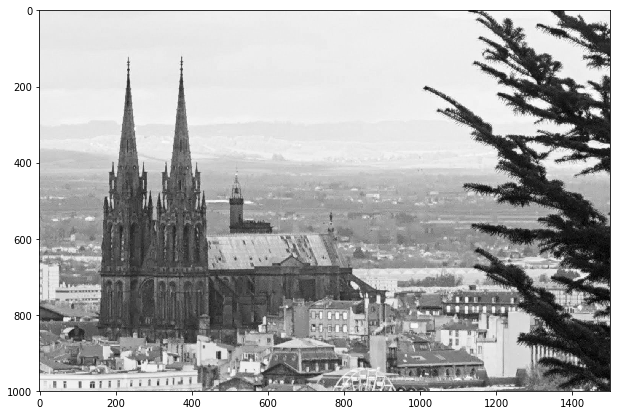

In [10]:
# Get the gray scale image
gray_image = get_gray_scale(image)

# Plot the result
plot_image(gray_image, h=7)

## Numerical operations on images

Since images are NumPy arrays, we can perform numerical operations very easily. Not all of them have a proper meaning, though, but it is interesting to explore the possibilities. First, we define two images which are the Clermont-Ferrand cathedral slightly shifted:

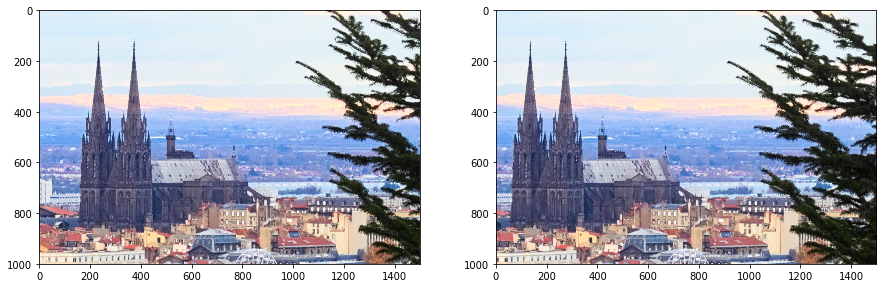

In [11]:
# Create the two images
image1 = im[500:1500, 1500:3000]
image2 = im[500:1500, 1600:3100]

# Plot the two images side-by-side
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2);

### Addition & subtraction

What if we add or subtract these pictures? One has to define what happens if the sum (or the difference) is out of the permitted range $[0, 255]$. Let's take the following convention: if the pixel is below 0, we set it to 0, and if it is above 255, we set it to 255. This can be done by taking the image with float (allowing above values) and operating the truncation at the end. The two following functions implement this "image addition/subtraction":

In [12]:
def add_pictures(im1, im2):
    s = im1.astype(float) + im2.astype(float)
    s[s>255] = 255
    s[s<0] = 0
    return s.astype(np.uint8)

def subtract_pictures(im1, im2):
    s = im1.astype(float) - im2.astype(float)
    s[s>255] = 255
    s[s<0] = 0
    return s.astype(np.uint8)

Let's try to plot the added and subtracted images:

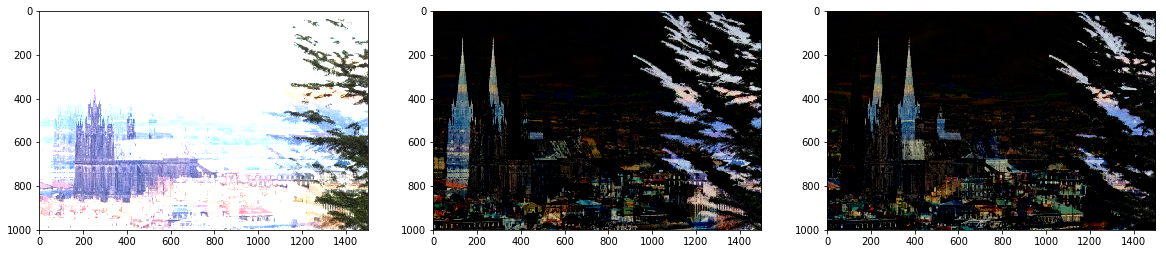

In [13]:
# Perform the operations
s12 = add_pictures(image1, image2)
d12 = subtract_pictures(image1, image2)
d21 = subtract_pictures(image2, image1)

# Plot the results side-by-side
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(s12)
plt.subplot(1, 3, 2)
plt.imshow(d12)
plt.subplot(1, 3, 3)
plt.imshow(d21);

When we sum the two pictures, we get something very bright (as expected) and we see the echo of the cathedral. After the subtraction (middle), we still see the echo but we get something very dark. The last plot shows the other difference, which looks quite cool, especially at the bottom of the cathedral!

### Modifying certain pixels

Another useful operation we can easily do with NumPy is to mask pixels satisfying a given condition. Let's say we want to mask all pixels whose red level is higher than the sum of their blue level and green level:

In [14]:
# Get the copy of colors (to be modifed latter) 
r, g, b = image[...,0].copy(), image[..., 1].copy(), image[..., 2].copy()

# Get the mask
th = add_pictures(g, b)
to_black = r>=th

# Perform the mask
r[to_black] = 0
g[to_black] = 0
b[to_black] = 0

One can also decide to set the too dark regions to white, for example when `r+g+b<=60`, without modifying the previous pixels:

In [15]:
# Get the new indices to set to white
to_white = r+b+g<=60

# White only pixel that were didn't touch by the previous mask
to_white = to_white * ~to_black

# Perform the whitening
r[to_white] = 255
g[to_white] = 255
b[to_white] = 255

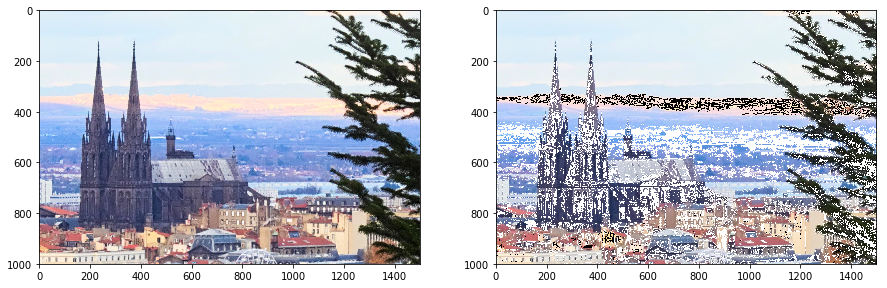

In [16]:
# Combine the three colors together
image_masked = np.stack([r, g, b], axis=2)

# Plot the results side-by-side
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image_masked);

### Modifying regions

We can use fancy indexing of NumPy to define a shape and modify only the pixels that are within this shape. For this example, let's consider a circle with a given center position $r_0=(x_0, y_0)$ and radius $R$. We will decrease the luminosity by scaling down all the pixels together. To start, let's write a function that returns a boolean 2D array which tells us whether a given $(x,y)$ pixel is in the circle or not. This will, again, involve using a meshgrid:

In [17]:
def idx_in_circle(im, x0, y0, R):
    lx, ly = im.shape[:2]
    X, Y = np.meshgrid(np.arange(0, ly), np.arange(0, lx))
    radius = ((X-x0)**2 + (Y-y0)**2)**0.5
    return radius<=R

We will now use this function to add 10 random shadowed circles. We will generate the center and radius of the circles using the `np.random.randint()` function. Note the use of packing/unpacking of arguments to call the `idx_in_circle()` function in a more concise and clear way, together with the `zip()` syntax:

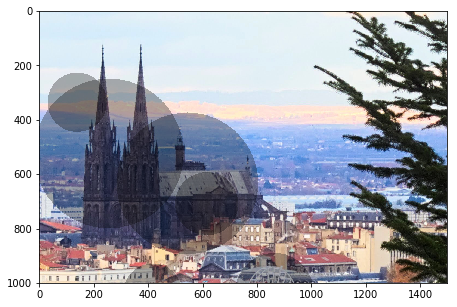

In [18]:
# Copy original image and modify it
result = image.copy()

# Get 10 random circles (in position and radius)
x0 = np.random.randint(low=100, high=1000, size=10)
y0 = np.random.randint(low=100, high=1500, size=10)
R0 = np.random.randint(low=50 , high=300 , size=10)

# For each of them, modify the picture
for circle in zip(x0, y0, R0):
    idx = idx_in_circle(image, *circle)
    result[idx] = result[idx]*0.7

# Plot the result
plt.figure(figsize=(10, 5))
plt.imshow(result);

## Image filters with NumPy


### Kernels, image blocks vs. windows

In image processing, a filter is a small 2D array $n\times n$ (also called a *kernel*) that is used to modify the value of each pixel using a *convolution* between a portion of the image and the kernel. These portions can either use every pixel only once by splitting the image into $(n \times n)$ blocks, or they can use every pixel several times by sliding $(n \times n)$ overlapping windows. The mathematical operation behind the name convolution is a simple sum over all elements from the window, weighted by the elements of the kernel.

To better understand the concept of kernels, blocks, and windows, let's now take an example of a `12x12` image and build both the blocks and sliding windows:

In [19]:
# Image definition
image = np.arange(12*12).reshape(12, 12)
print('image = \n{}'.format(image))

# Build-up 3x3 independant blocks
step3 = range(0, 12, 3)
blocks_3x3 = np.array([image[i:i+3, j:j+3] for i in step3 for j in step3])
blocks_3x3 = blocks_3x3.reshape(4, 4, 3, 3) # Organize the 16 blocks into a 4x4 grid
print('\nBlock[1, 1] = \n{}'.format(blocks_3x3[1, 1]))

# Built-up 3x3 windows for pixel far from the border (to avoid technical issues)
windows_3x3 = np.array( [image[i-1:i+2, j-1:j+2] for i in range(1, 11) for j in range(1, 11)] )
windows_3x3 = windows_3x3.reshape(10, 10, 3, 3) # Organize the 100 blocks into a 10x10 grid
print('\nWindow[3, 2] = \n{}'.format(windows_3x3[3, 2]))

image = 
[[  0   1   2   3   4   5   6   7   8   9  10  11]
 [ 12  13  14  15  16  17  18  19  20  21  22  23]
 [ 24  25  26  27  28  29  30  31  32  33  34  35]
 [ 36  37  38  39  40  41  42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71]
 [ 72  73  74  75  76  77  78  79  80  81  82  83]
 [ 84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107]
 [108 109 110 111 112 113 114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131]
 [132 133 134 135 136 137 138 139 140 141 142 143]]

Block[1, 1] = 
[[39 40 41]
 [51 52 53]
 [63 64 65]]

Window[3, 2] = 
[[38 39 40]
 [50 51 52]
 [62 63 64]]


For instance, the number `39` can only be on an edge of a block (used once), while it can be anywhere for the sliding windows (used several times). Let's now define a `3x3` kernel and apply it to `blocks_3x3[1,1]`.

In [20]:
# Definition
kernel = np.arange(9).reshape(3, 3)/20
print('kernel = \n{}'.format(kernel))

# Convolution with the block[1, 1]
this_block = blocks_3x3[1, 1]
new_pixel = np.sum(kernel * this_block)
print('\nProduct of elements = \n{}'.format(kernel * this_block))
print('\nNew pixel = {:.1f} (vs an old pixel of {})'.format(new_pixel, this_block[1, 1]))

kernel = 
[[0.   0.05 0.1 ]
 [0.15 0.2  0.25]
 [0.3  0.35 0.4 ]]

Product of elements = 
[[ 0.    2.    4.1 ]
 [ 7.65 10.4  13.25]
 [18.9  22.4  26.  ]]

New pixel = 104.7 (vs an old pixel of 52)


Let's now apply the kernel defined above to both blocks and sliding windows. We can also represent the image before filtering, after block-based filtering, and window-based filtering.

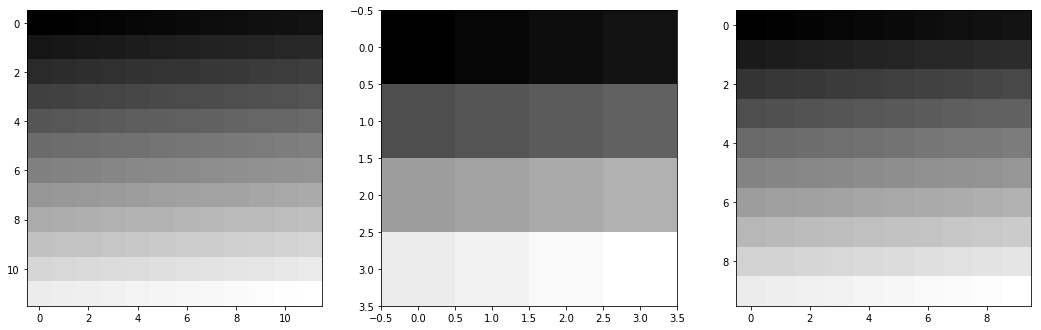

In [21]:
# Apply block-based filter
block_filtered = np.sum(blocks_3x3*kernel[np.newaxis, np.newaxis], axis=(2, 3))
block_filtered[block_filtered>255]=255
block_filtered[block_filtered<0]=0

# Apply window-based filter
window_filtered = np.sum(windows_3x3*kernel, axis=(2, 3))
window_filtered[window_filtered>255]=255
window_filtered[window_filtered<=0]=0

# Plot the results side-by-side
plt.figure(figsize=(18, 7))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(block_filtered, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(window_filtered, cmap='gray');

**Important comment:** The block view is not too heavy on memory, but the window view can explode quite rapidly. Indeed, for a kernel of $n \times n$, the window view is $n^2$ larger than the original array. If you manipulate millions of images, this can be problematic. For this reason, we will use a built-in `scipy.signal` function to perform the "sliding windows application" called `convolve2D()`. However, in the next section, we will study how to efficiently perform the "block approach" using a deeper NumPy feature: strides.

**Generalization to RGB image.** Before moving forward, we need to consider the three colors of an image to apply a filter, which has some implications in terms of broadcasting structure. First, let's define a dummy RGB image using a meshgrid (careful, x and y are reversed with respect to imshow) and three functions for each color:

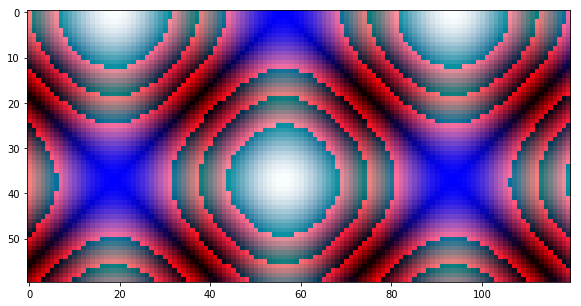

In [129]:
# Create a shaped image
def get_dummy_image(nx=600, ny=1200):
    X, Y = np.meshgrid(np.linspace(0, 10, ny), np.linspace(0, 5, nx))
    f = lambda n: np.abs(np.sin(X)**n+np.cos(Y)**n)
    im = np.stack([2*f(1), 0.5*f(3), 0.5*f(2)], axis=2)*255
    return im.astype(np.uint8)

im = get_dummy_image(nx=60, ny=120)
plot_image(im)

In order to achieve proper broadcasting, we need to extend the kernel with a third dimension for the colors, which can be done via the syntax `kernel[:,:,np.newaxis]`. This way, the kernel will be automatically duplicated for each color, and its application can be properly vectorized.

[188 218 223]


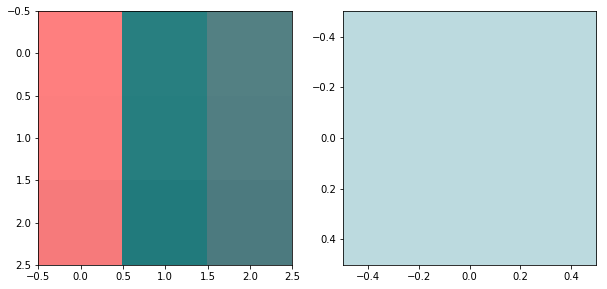

In [130]:
# Kernel application with the proper broadcasting over colors only for the first block
kernel = np.arange(9).reshape(3, 3)/20
new_pixel = np.sum(im[0:3, 0:3, :]*kernel[:,:,np.newaxis], axis=(0,1), dtype=np.uint8)
print(new_pixel)

# Plotting the 9 considered pixels and the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im[0:3, 0:3, :])
plt.subplot(1, 2, 2)
plt.imshow(new_pixel.reshape(1, 1, 3));

### Image blocks: Intuitive but inefficient approach

The most intuitive approach is to apply the filter to each block, involving an explicit *loop* over all the blocks of the image. Let's follow this approach for now, defining a function that applies the kernel to the block indexed by $(i, j)$. Note that we didn't handle the boundaries properly, i.e. if the size of the image is not exactly $n$ times the size of the kernel.

In [131]:
def apply_filter_one_block(im, kn, i, j):
    dx, dy = kn.shape
    start_i, end_i = i*dx, (i+1)*dx
    start_j, end_j = j*dy, (j+1)*dy
    indices = (slice(start_i, end_i), slice(start_j, end_j), slice(None, None))
    pixel = np.sum(im[indices].astype(float)*kn[:, :, np.newaxis], axis=(0, 1))
    pixel[pixel<0]=0
    pixel[pixel>255]=255
    return pixel.astype(np.uint8)

# Testing with a dummy image and averaging filter (1 every where)
im = get_dummy_image(nx=12, ny=12)
kernel = np.ones(shape=(3, 3))/9.
print('new pixel = {}'.format(apply_filter_one_block(im, kernel, 1, 1)))

new pixel = [98 57 79]


Let's now try to apply the strategy to a real image with dimensions $1200 \times 1200$ using two kernel sizes: $3 \times 3$ and $6 \times 6$:

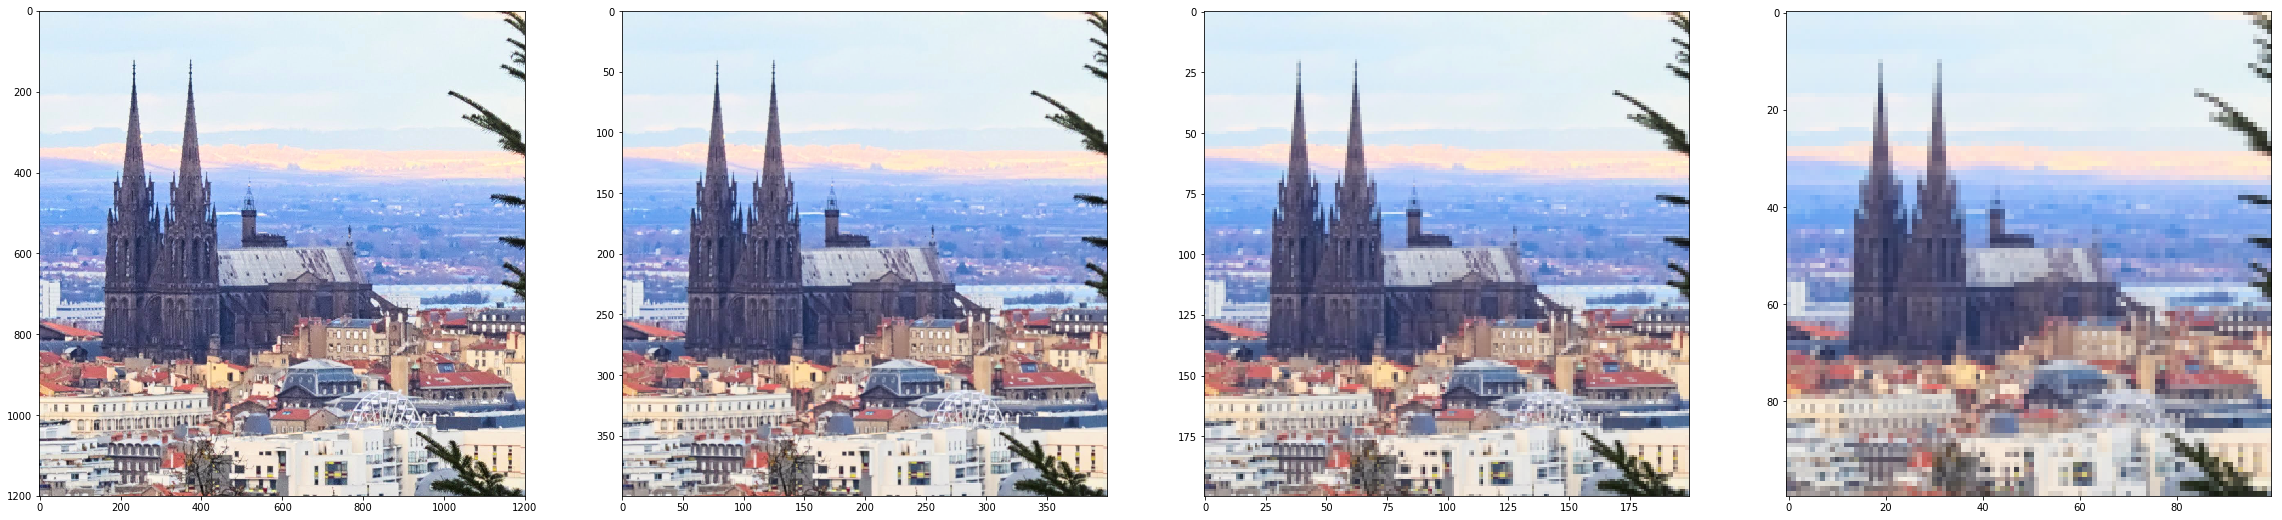

In [132]:
# Testing with a real image
image_full = plt.imread('../data/image_test.jpg')
im = image_full[500:1700, 1500:2700]

# 3x3 kernel with all ones
kernel = np.ones(shape=(3, 3))/(3*3)
im3x3 = np.array([[apply_filter_one_block(im, kernel, i, j) for j in range(0, 400)] for i in range(0, 400)])

# 6x6 kernel with all ones
kernel = np.ones(shape=(6, 6))/(6*6)
im6x6 = np.array([[apply_filter_one_block(im, kernel, i, j) for j in range(0, 200)] for i in range(0, 200)])

# 12x12 kernel with all ones
kernel = np.ones(shape=(12, 12))/(12*12)
im12x12 = np.array([[apply_filter_one_block(im, kernel, i, j) for j in range(0, 100)] for i in range(0, 100)])

# Plotting the result
fig = plt.figure(figsize=(40, 10))
for i, this_im in enumerate([im, im3x3, im6x6, im12x12]):
    plt.subplot(1, 4, i+1)
    plt.imshow(this_im)

This is also possible to time the loop operation with the `%timeit` magic command. Let's do it in the full picture.

In [26]:
im_test = image_full[:3006, :4008]
kernel = np.ones(shape=(3, 3))/(3*3)
%timeit np.array([[apply_filter_one_block(im_test, kernel, i, j) for j in range(0, 1336)] for i in range(0, 1002)])

19.6 s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes approximately 20 seconds to process a 12 megapixel image. This shows that this approach is too slow for systematic treatment, especially when considering a larger number of images to process. This was expected since we have already mentioned that explicit loops in Python are slow. The goal of the next section is to use the power of NumPy to remove the loop and speed up this computation.

### Image blocks: fast NumPy-based approach

The idea is to first convert the image array from the dimensions `(Nx, Ny, 3)` to `(Nx_new, Ny_new, Nx_kernel, Ny_kernel, 3)`, where `(Nx_new, Ny_new)` is the dimension of the "image of blocks". Once this is done, one can simply multiply and sum over axes 2 and 3.

The other approach is quite advanced but also quite powerful: `numpy.lib.stride_tricks.as_strided()`. Strides are basically a tuple of bytes of memory to jump from one element to another in each dimension. In other words, it's the byte separation between consecutive items for each dimension. This byte manipulation *doesn't duplicate the data but rather views them in a different way*, which is much more efficient from a memory point of view. This is the approach behind broadcasting and is, by far, *the fastest approach*. Let's go step by step to understand the strides concept.

In [36]:
# Small image as a copy of a sub-image from out favorite test
im_small = image_full[1000:1006, 1000:1006].copy()

# Print few information, including the number of bytes 6x6x3x1 = 108 
print('Shape     : {}'.format(im_small.shape))
print('Dtype     : {}'.format(im_small.dtype))
print('Item size : {}'.format(im_small.itemsize))
print('Nbytes    : {}'.format(im_small.nbytes))

Shape     : (6, 6, 3)
Dtype     : uint8
Item size : 1
Nbytes    : 108


*Reminder:* 1 byte (or octet) is 8 bits. One bit is a single number being 0 or 1. The 8-bit image we are looking at in this lecture is then 1 byte per color and per pixel. The above number then makes perfect sense.

Let's try to compute the byte jump by hand first. In the third axis (color) axis, the jump between two consecutive items is just the item size so 1 byte. For the y-axis you jump 3 by 3 element to jump over all colors and reach the next position. This lead to a byte jump of 3 bytes. Finally, to jump over the next x-axis value, one needs to loop over all $y$-values and 3 colors, which makes $6 \times 3 = 18$. So the `im.strides` command should give `(18, 3, 1)`.

In [35]:
print(im_small.strides)

(18, 3, 1)


Now, we can manipulate these jumps to organize the numbers differently. Let's do it for only one color and a $4\times 4$ array, to have a smaller array and follow the numbers individually.

In [60]:
# 4x4 array and getting strides
a = im_small[:4, :4, 0].copy()
jumps = a.strides
print('a = \n{}'.format(a))
print('strides = {}'.format(jumps))

a = 
[[124 120 114 111]
 [123 119 115 112]
 [122 119 115 113]
 [120 118 116 115]]
strides = (4, 1)


Let's say that we want to create an array of `2x2` blocks, with each block containing `2x2` elements. This would result in a new shape of `(2, 2, 2, 2)`. The first block would look like:

```
[124, 120]
[123, 119]
```

In terms of strides, this means that the memory jump between two elements along the second-to-last axis is equivalent to a jump of 4 bytes. This corresponds to the jump between two elements along the first axis of the original array. In order to have the second block like:

```
[114, 111]
[115, 112]
```

We need to jump along the second axis by 2 bytes, which is the size of the jump to go from `124` to `114`. Finally, for a jump along the first axis, we need to go from `124` to `122`, which accounts for 8 bytes (corresponding to the first two lines of `a`).

In [66]:
# Re-agencemement using the strides 
new_shape = (2, 2, 2, 2)
new_jumps = (8, 2, 4, 1)

# Create the new array
from numpy.lib.stride_tricks import as_strided
a_new = as_strided(a, strides=new_jumps, shape=new_shape)

# Print the result
print('a_new = \n{}'.format(a_new))
print('strides = {}'.format(new_jumps))

a_new = 
[[[[124 120]
   [123 119]]

  [[114 111]
   [115 112]]]


 [[[122 119]
   [120 118]]

  [[115 113]
   [116 115]]]]
strides = (8, 2, 4, 1)


Once we did this by hand, we can try to automate it given the size of the blocks we want to make and the size of the image. Let's take the example of a `(100, 100)` image with a `(3, 3)` block.

In [82]:
# 100x100 image
im100x100 = image_full[:100, :100, 0].copy()

# Convering each shape into numpy array for element-wise operation
im_shape = np.array(im100x100.shape) # image dimensions
bl_shape = np.array((3, 3))     # block dimensions

# Shape of the "image of blocks", as floor division
im_blocks_shape = im_shape // bl_shape
print(im_blocks_shape)

# Full dimension is a concatenation of corresponding shapes
new_shape = tuple(im_blocks_shape) + tuple(bl_shape)
print(new_shape)

[33 33]
(33, 33, 3, 3)


Now, it is a matter of automatically obtaining the new strides based on the image and block sizes. The jumps corresponding to the first two dimensions are simply the original picture jumps multiplied by the block shape. Specifically, we want the following:

- Along the $y$-axis (2nd axis): take the 1st element, then the `1+Ny_block`'s one, etc ... so the memory jump is `old_jump_y * Ny_block`.
- Along the $x$-axis (1st axis): take the 1st element, then the `1+Nx_block`'s one, so the memory jump is also `old_jump_x * Nx_block`.

As for the last two axes, i.e., the navigation inside a block, this is just the original memory jumps.

In [88]:
# Get old strides as numpy array
old_strides = np.array(im100x100.strides)
print(old_strides)

# Form new strides
new_strides = tuple(old_strides*bl_shape) + tuple(old_strides)
print(new_strides)

[100   1]
(300, 3, 100, 1)


In [97]:
# Form the blocks and check this is correct for the first few
im100x100_blocked = as_strided(im100x100, strides=new_strides, shape=new_shape, writeable=False)

# Print the original image
print('Original image: \n{}'.format(im100x100[:6, :6]))

# Print the first few blocks
print('\nFirst 3x3 blocks: \n',format(im100x100_blocked[:2, :2]))

Original image: 
[[18 18 22 26 23 21]
 [21 23 19 21 29 30]
 [31 31 17 13 25 24]
 [29 24 15 17 28 31]
 [25 12 12 19 20 23]
 [13  2 12 27 28 38]]

First 3x3 blocks: 
 [[[[18 18 22]
   [21 23 19]
   [31 31 17]]

  [[26 23 21]
   [21 29 30]
   [13 25 24]]]


 [[[29 24 15]
   [25 12 12]
   [13  2 12]]

  [[17 28 31]
   [19 20 23]
   [27 28 38]]]]


We are now ready to build a function that applies a kernel per block (accounting for the additional axis for colors - not taken into account above), where the last step is just operating the sum:

In [120]:
def apply_filter_strides(image, kernel):
    from numpy.lib.stride_tricks import as_strided

    # Get the new shape
    m_shape, image_shape = np.array(kernel.shape), np.array(image.shape)
    new_shape = tuple(image_shape[:2] // m_shape) + tuple(m_shape) + (image_shape[-1],)
    
    # Get the new strides
    new_strides = tuple(image.strides[:2] * m_shape) + image.strides
    
    # Get the new blocked image (Nx_new, Ny_new, Nx_mask, Ny_mask, 3)
    blocked_image = as_strided(image, shape=new_shape, strides=new_strides, writeable=False)
    
    # Apply the mask with the proper broadcasting
    kernel_reshaped = kernel[np.newaxis, np.newaxis, :, :, np.newaxis]
    result = np.sum(blocked_image*kernel_reshaped, axis=(2, 3))
    
    # Cleaning
    result[result<0] = 0
    result[result>255] = 255
    
    # Return
    return result.astype(np.uint8)

It is worth mentioning that all this code is already written in some of the tools mentioned at the beginning of this chapter. However, the goal here is to learn how the tools are made (and possibly make new ones!). To finalize the process, we can first compare if we get the same result as the explicit loop function, and then compare the timing for those two functions:

In [124]:
# Check compatibility with the previous function
im = image_full[500:1700, 1500:2700]
kernel = np.ones(shape=(12, 12))/(12*12)
im12x12_loop = np.array([[apply_filter_one_block(im, kernel, i, j) for j in range(0, 100)] for i in range(0, 100)])
im12x12_strides = apply_filter_strides(im, kernel)

# Check that all pixels are the same in both images
print('Are the two results equal? {}'.format(np.all(im12x12_strides==im12x12_loop)))

Are the two results equal? True


In [135]:
# Exectution time
kernel = np.ones(shape=(3, 3))/(3*3)
%timeit apply_filter_strides(image_full, kernel)

866 ms ± 6.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The fully vectorized approach based on stride manipulations is more than 20 times faster than the explicit loop.

## Few typical filters


### Few utility functions

In order to perform image processing in a systematic way, we need to build a few helper functions which are written below. They are all based on the above developments, except the sliding windows application using the `scipy.signal.convolve2d()` function. The full documentation of this function, together with some examples, can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) and will not be discussed in this lecture.


*Note:* There is a slight difference in the definition of the `convolve2d()` function and the weighted sum used in the blocks approach. The `convolve2d()` function performs the weighted sum using the transposed kernel, which explains why the considered kernel in the below function is `kernel.T`.

**Clean image (value and data type)**:

In [136]:
def clean_image(image): 
    image[image < 0] = 0
    image[image > 255] = 255
    return image.astype(np.uint8)

**Normalise the kernel values:**

In [137]:
def normalize_filter(kernel):
    if np.sum(kernel) != 0:
        return kernel/np.sum(kernel)
    else:
        return kernel

**Apply filter with sliding windows** (based on `scipy.signal` 2D convolution function)

In [179]:
def apply_filter_windows(image, kernel):
    from scipy.signal import convolve2d
    
    # Performing 2D convolution on every color
    args = {'mode': 'same', 'boundary': 'fill', 'fillvalue': 0}
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    filtered_colors = [convolve2d(ch, kernel.T, **args) for ch in [r, g, b]]
    
    # Stacking all colors together
    filtered_image = np.stack(filtered_colors, axis=2)
    
    # Result
    return clean_image(filtered_image)

**Applying filters with blocks** (based on stride-based manipulation)

In [180]:
def apply_filter_blocks(image, kernel):
    from numpy.lib.stride_tricks import as_strided

    # Get the new shape
    m_shape, image_shape = np.array(kernel.shape), np.array(image.shape)
    new_shape = tuple(image_shape[:2] // m_shape) + tuple(m_shape) + (image_shape[-1],)
    
    # Get the new strides
    new_strides = tuple(image.strides[:2] * m_shape) + image.strides
    
    # Get the new blocked image (Nx_new, Ny_new, Nx_mask, Ny_mask, 3)
    blocked_image = as_strided(image, shape=new_shape, strides=new_strides, writeable=False)

    # Filtered image
    kernel_reshaped = kernel[np.newaxis, np.newaxis, :, :, np.newaxis]
    filtered_image = np.sum(blocked_image*kernel_reshaped, axis=(2, 3))
 
    # Result
    return clean_image(filtered_image)

**Test image definition:**

In [181]:
image = image_full[500:1500, 1500:3000]

### Blurry filter

The blurry filter just perform an average of all surrouding pixels. The corresponding kernel is a constant value in at position, with a sum of 1.0. Below, the blurry filter is applied for both sliding window and bloc approaches. *Caution:* the sliding window for a $(100 \times 100)$ kernel takes several minutes.

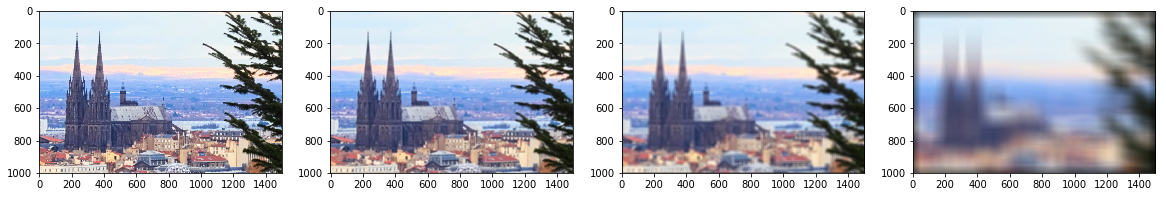

In [152]:
# Windows application
plt.figure(figsize=(20, 5))
for i, n in enumerate([3, 10, 20, 100]):
    kernel = normalize_filter(np.ones(shape=(n, n)))
    result = apply_filter_windows(image, kernel)
    plt.subplot(1, 4, i+1)
    plt.imshow(result)

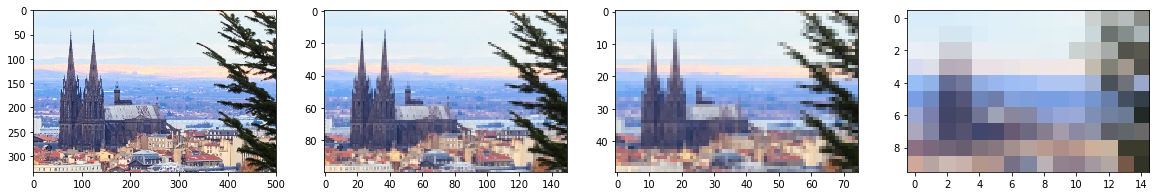

In [151]:
# Block application
plt.figure(figsize=(20, 5))
for i, n in enumerate([3, 10, 20, 100]):
    kernel = normalize_filter(np.ones(shape=(n, n)))
    result = apply_filter_blocks(image, kernel)
    plt.subplot(1, 4, i+1)
    plt.imshow(result)

### Edge detection

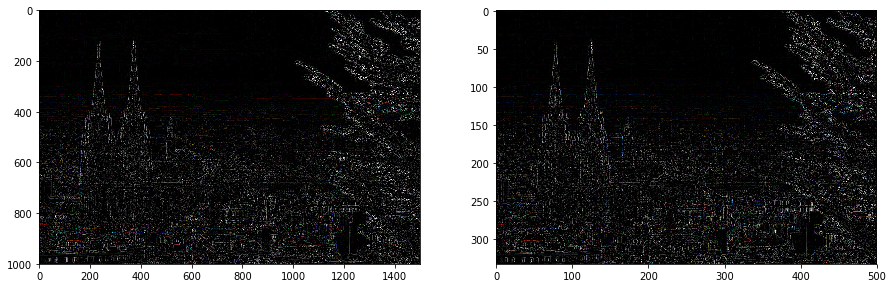

In [182]:
filter_border = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

filter_border = normalize_filter(filter_border)
border_windows = apply_filter_windows(image, filter_border)
border_blocks = apply_filter_blocks(image, filter_border)

# Plotting the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(border_windows)
plt.subplot(1, 2, 2)
plt.imshow(border_blocks);

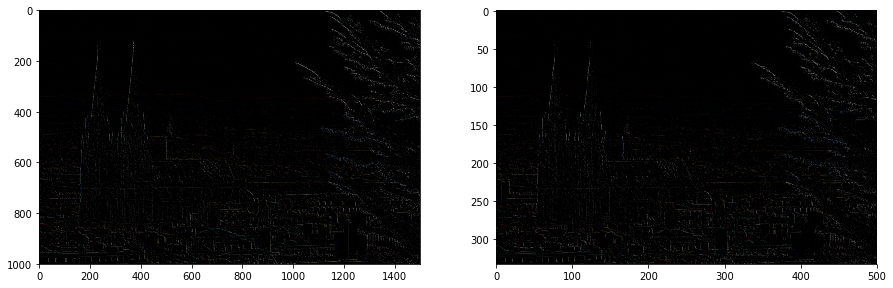

In [185]:
# Border which are direction-dependent: top-left
filter_topleft = np.array([
    [ 0,  0, -1],
    [ 0,  1,  0],
    [ 0,  0,  0]
])

filter_topright = normalize_filter(filter_topleft)
border_windows = apply_filter_windows(image, filter_topleft)
border_blocks = apply_filter_blocks(image, filter_topleft)

# Plotting the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(border_windows)
plt.subplot(1, 2, 2)
plt.imshow(border_blocks);

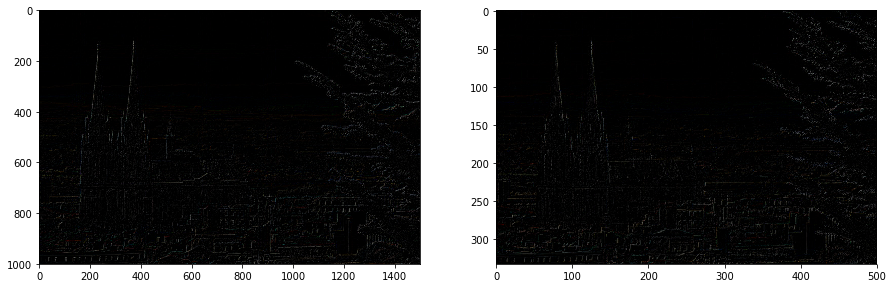

In [195]:
# Border which are direction-dependent: top-right
filter_topright = np.array([
    [ -1,  0,  0],
    [  0,  1,  0],
    [  0,  0,  0]
])

filter_topleft = normalize_filter(filter_topright)
border_windows = apply_filter_windows(image, filter_topright)
border_blocks = apply_filter_blocks(image, filter_topright) # Still a difference between block/window-approaches

# Plotting the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(border_windows)
plt.subplot(1, 2, 2)
plt.imshow(border_blocks);

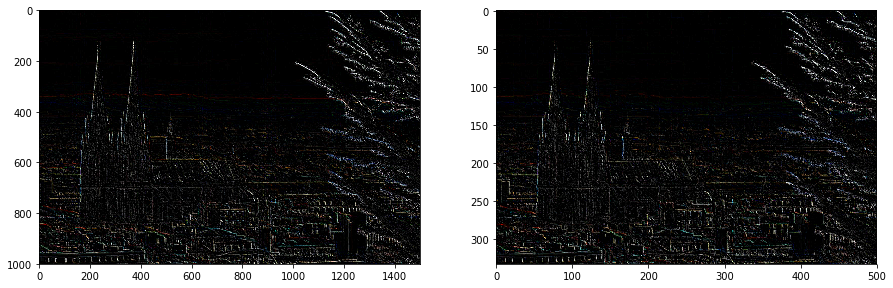

In [194]:
# Playing with intensity of the border
filter_topleft = np.array([
    [  0,  0, -3],
    [  0,  3,  0],
    [  0,  0,  0]
])

filter_topleft = normalize_filter(filter_topleft)
border_windows = apply_filter_windows(image, filter_topleft)
border_blocks = apply_filter_blocks(image, filter_topleft)

# Plotting the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(border_windows)
plt.subplot(1, 2, 2)
plt.imshow(border_blocks);

### Sharpen filter

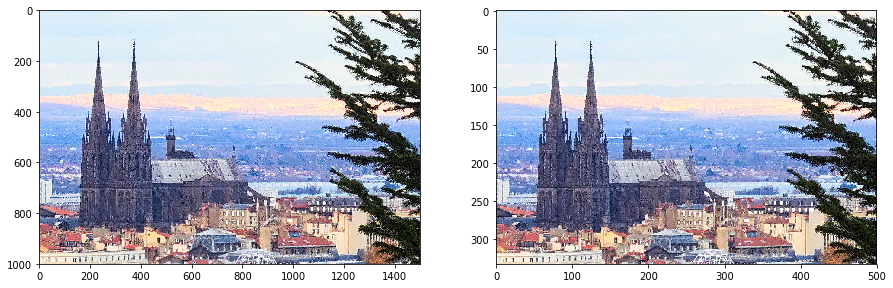

In [196]:
filter_sharpen = np.array([
    [  0, -1,  0],
    [ -1,  5, -1],
    [  0, -1,  0]
])

filter_sharpen = normalize_filter(filter_sharpen)
sharpen_windows = apply_filter_windows(image, filter_sharpen)
sharpen_blocks = apply_filter_blocks(image, filter_sharpen)

# Plotting the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(sharpen_windows)
plt.subplot(1, 2, 2)
plt.imshow(sharpen_blocks);